**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [2]:
## mounting google drive to read data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# CNN_assignment.zip is the file that contains the dataset
#unzipping it to runtime folder
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip"

Archive:  /content/gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train images count - ",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Train test count - ",image_count_test)

Train images count -  2239
Train test count -  118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
print("total number of classes - ", len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
total number of classes -  9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

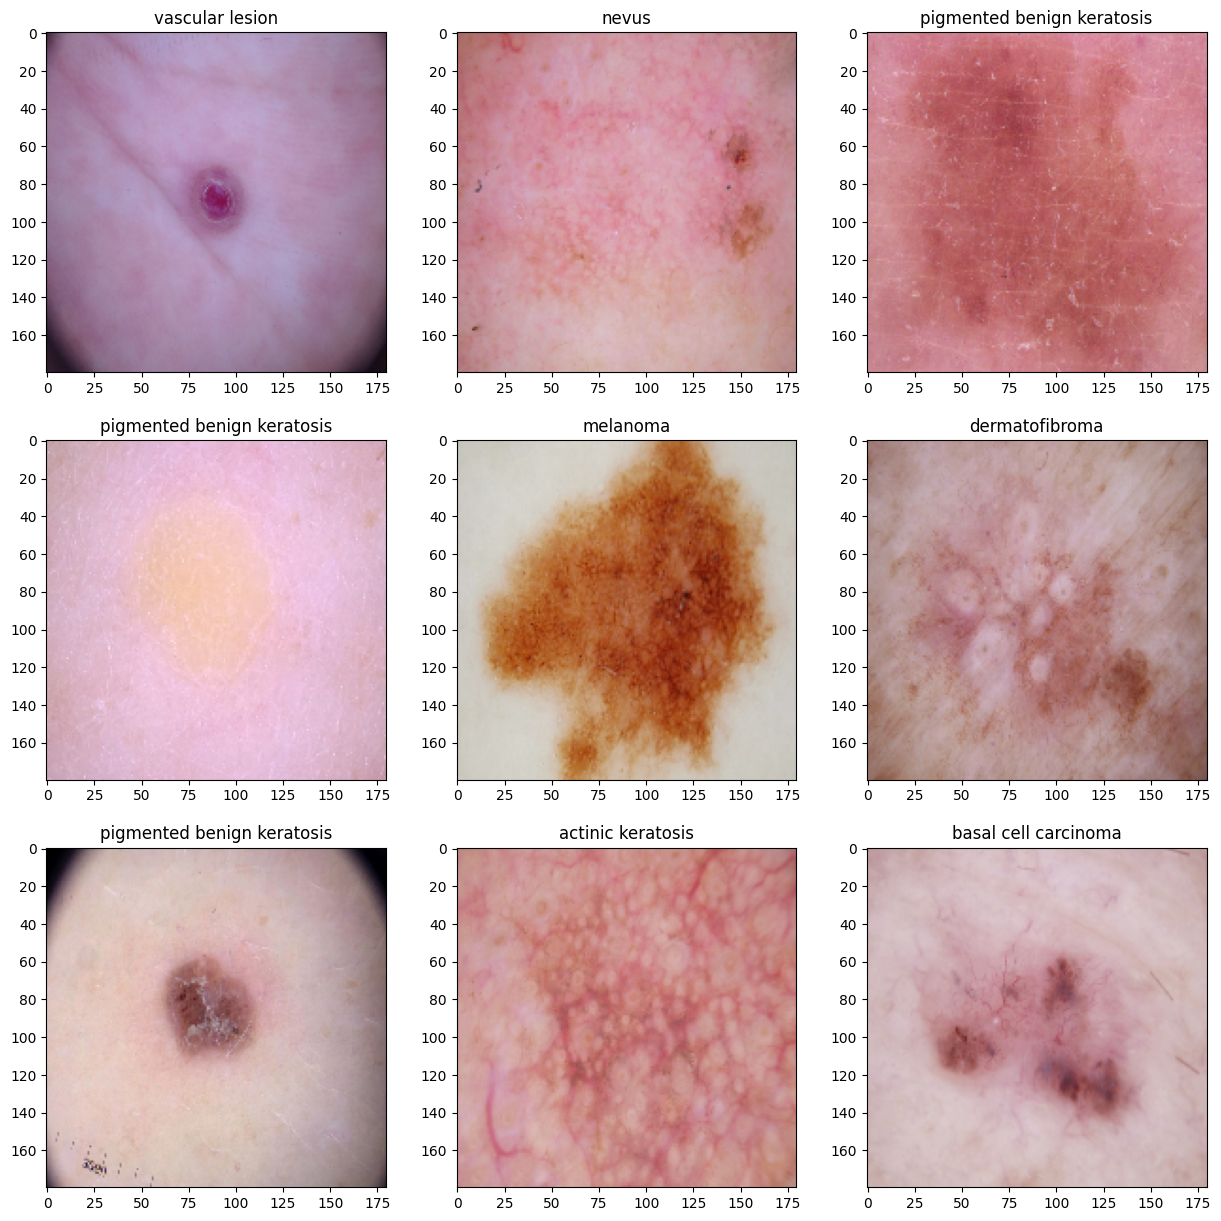

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(15, 15))
for image, label in train_ds.take(1):
  for classSkin in range(9):
    ax = plt.subplot(3, 3, classSkin + 1)
    plt.imshow(image[classSkin].numpy().astype("uint8"))
    plt.title(class_names[label[classSkin]])

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
# Number of classes is 9
cnnModel = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(9)
])

In [13]:
# model summary
cnnModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
optimizerFunc = 'adam'
lossFunc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
cnnModel.compile(optimizer=optimizerFunc,
              loss=lossFunc,
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
cnnModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

### Train the model

In [16]:
epochs = 20
batch_size = 32

history = cnnModel.fit(train_ds, batch_size=batch_size, validation_data=val_ds, epochs=epochs )

Epoch 1/20
56/56 [==============================] - 31s 73ms/step - loss: 2.0127 - accuracy: 0.2467 - val_loss: 1.8686 - val_accuracy: 0.2931
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.7325 - accuracy: 0.3677 - val_loss: 1.6527 - val_accuracy: 0.3669
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4794 - accuracy: 0.4833 - val_loss: 1.4273 - val_accuracy: 0.5213
Epoch 4/20
56/56 [==============================] - 1s 25ms/step - loss: 1.4068 - accuracy: 0.4972 - val_loss: 1.3981 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 1s 25ms/step - loss: 1.3462 - accuracy: 0.5273 - val_loss: 1.4073 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2414 - accuracy: 0.5692 - val_loss: 1.3930 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.1548 - accuracy: 0.5871 - val_loss: 1.5772 - val_accuracy: 0.5011
Epoch 8/20
5

### Visualizing training results

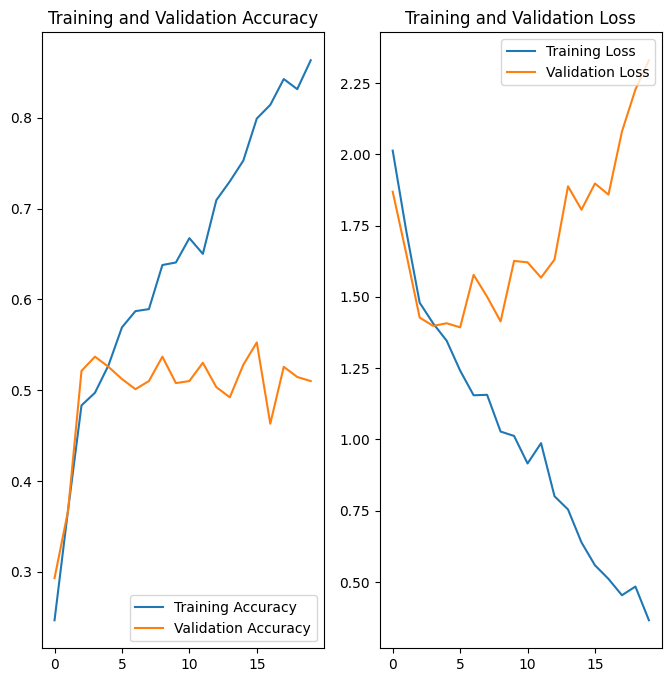

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see there is a *significant difference between training and validation accuracy* and the *loss is way more in validation set than training set* which implies *model has overfit* .

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [18]:
loss, accuracy = cnnModel.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = cnnModel.evaluate(val_ds, verbose=1)

print("Training Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Training Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 9ms/step - loss: 2.3297 - accuracy: 0.5101
Training Accuracy:  0.8839285969734192
Validation Accuracy:  0.5100671052932739
Training Loss:  0.321676105260849
Validation Loss 2.3297107219696045


### Write your findings here

We can see that the ***training accuracy is ~89%*** and ***validation accuracy is ~ 51%.***

This is clear evidence of ***model overfitting***. We need to appropriately use data augumentation strategies to increase training data points.

In [19]:
# importing required libraries
import keras
!pip install keras-cv
import keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 17.2 MB/s eta 0:00:00
Using TensorFlow backend


In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomContrast(0.5),
    layers.RandomBrightness(0.3),
    keras_cv.layers.RandomColorDegeneration(0.5)
])

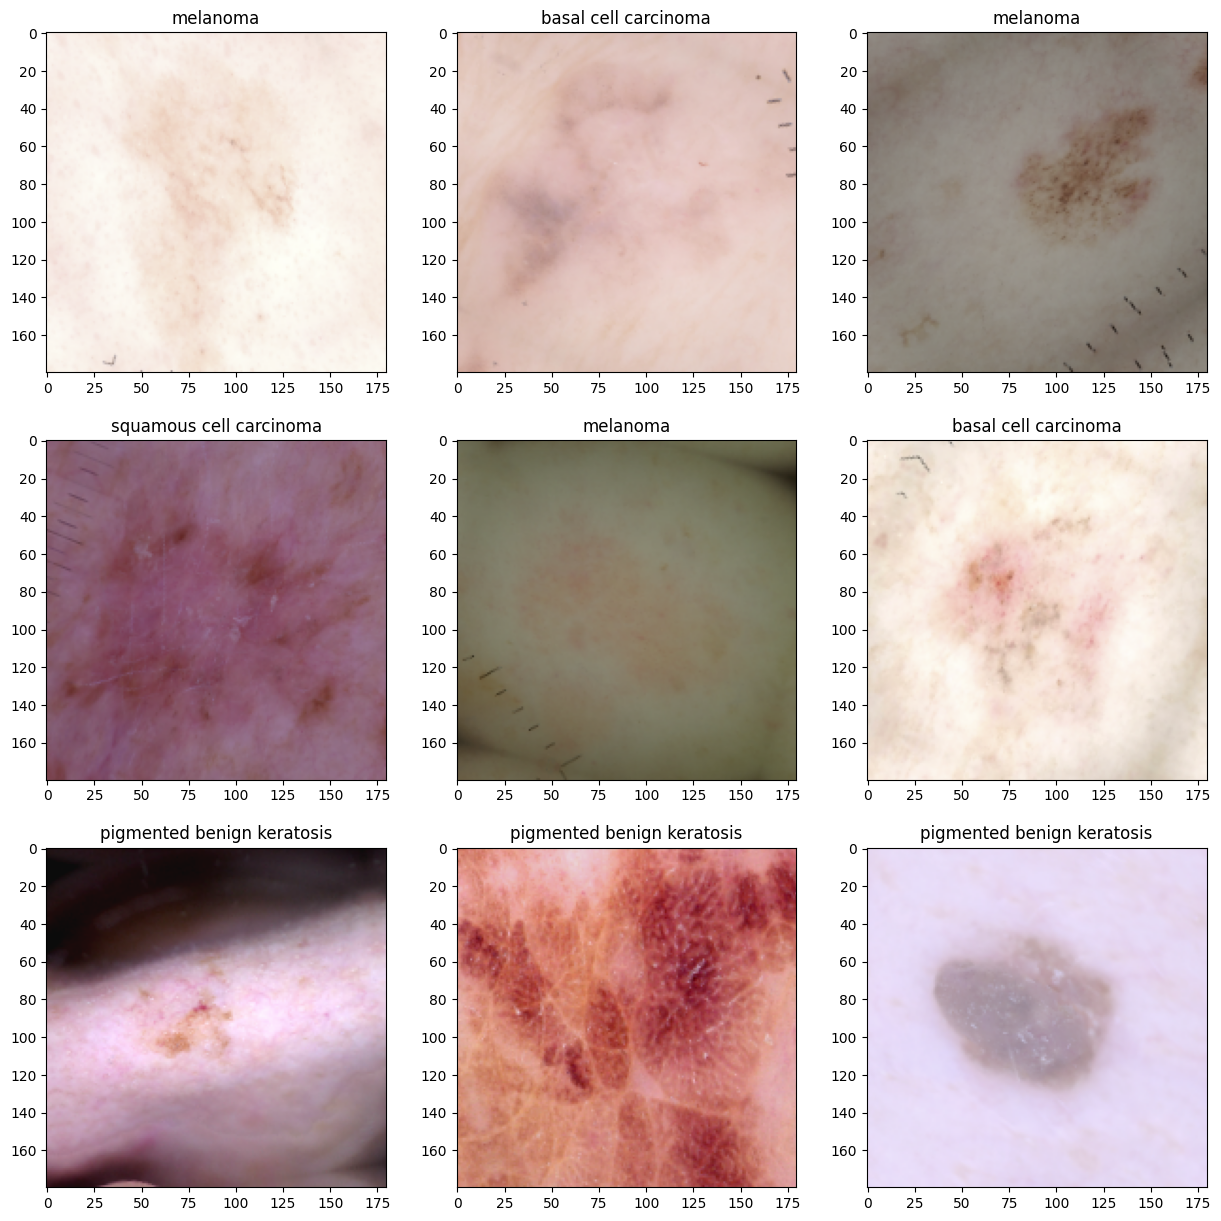

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(15, 15))
for image, label in train_ds.take(1):
  for classSkin in range(9):
    ax = plt.subplot(3, 3, classSkin + 1)
    plt.imshow(data_augmentation(image)[classSkin].numpy().astype("uint8"))
    plt.title(class_names[label[classSkin]])

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here
dropoutConv=0.05
dropoutDense=0.25

cnnModelAugment = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropoutConv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropoutConv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropoutConv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropoutDense),
    tf.keras.layers.Dense(9)
])


### Compiling the model

In [23]:
## Your code goes here
cnnModelAugment.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 10
history = cnnModelAugment.fit(train_ds, epochs = epochs, validation_data=val_ds)

Epoch 1/20
56/56 [==============================] - 13s 71ms/step - loss: 2.1308 - accuracy: 0.1780 - val_loss: 2.0666 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 3s 60ms/step - loss: 2.0186 - accuracy: 0.2238 - val_loss: 1.9951 - val_accuracy: 0.2550
Epoch 3/20
56/56 [==============================] - 4s 65ms/step - loss: 1.9748 - accuracy: 0.2511 - val_loss: 1.9078 - val_accuracy: 0.3423
Epoch 4/20
56/56 [==============================] - 3s 61ms/step - loss: 1.9152 - accuracy: 0.2879 - val_loss: 1.7669 - val_accuracy: 0.3937
Epoch 5/20
56/56 [==============================] - 3s 57ms/step - loss: 1.8089 - accuracy: 0.3387 - val_loss: 1.6770 - val_accuracy: 0.3937
Epoch 6/20
56/56 [==============================] - 3s 46ms/step - loss: 1.7411 - accuracy: 0.3711 - val_loss: 1.7846 - val_accuracy: 0.3132
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6596 - accuracy: 0.3878 - val_loss: 1.5386 - val_accuracy: 0.4541
Epoch 8/20
5

### Visualizing the results

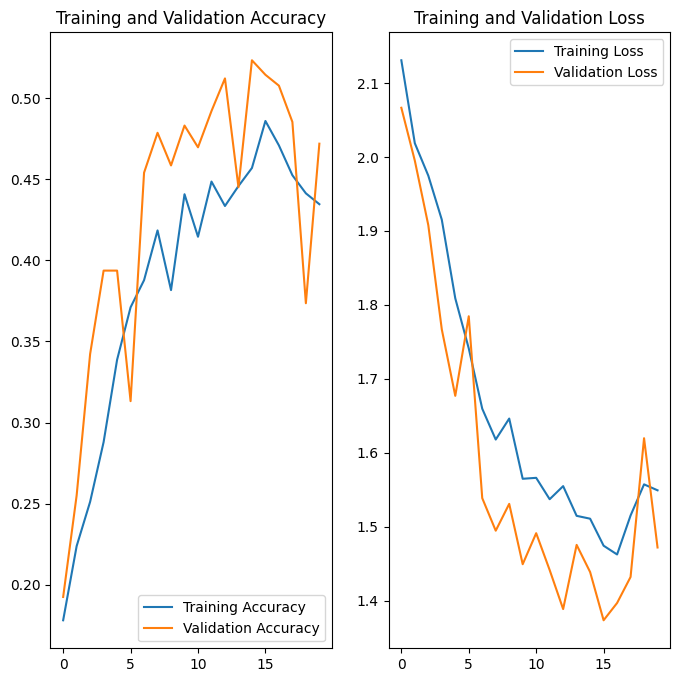

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

We can see that *training and validation accuracy after augmentation has come closer than before*. But the *accuracy has dropped down significantly*. Moreover training loss is less and validation loss is way more imlying *model is still overfitting* .

In [26]:
loss, accuracy = cnnModelAugment.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = cnnModelAugment.evaluate(val_ds, verbose=1)

print("Training Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Training Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 10ms/step - loss: 1.4683 - accuracy: 0.4653
Training Accuracy:  0.4849330484867096
Validation Accuracy:  0.46532437205314636
Training Loss:  1.4380022287368774
Validation Loss 1.4683442115783691


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
## Your code goes here.
path_list=[]
lable_list=[]
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lable_list.append(i)
dataframe_dict_original = dict(zip(path_list, lable_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df.head()

Path              Label
0  /content/Skin cancer ISIC The International Sk...  actinic keratosis
1  /content/Skin cancer ISIC The International Sk...  actinic keratosis
2  /content/Skin cancer ISIC The International Sk...  actinic keratosis
3  /content/Skin cancer ISIC The International Sk...  actinic keratosis
4  /content/Skin cancer ISIC The International Sk...  actinic keratosis

In [28]:
#value counts for each class before augmentation
original_df.Label.value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

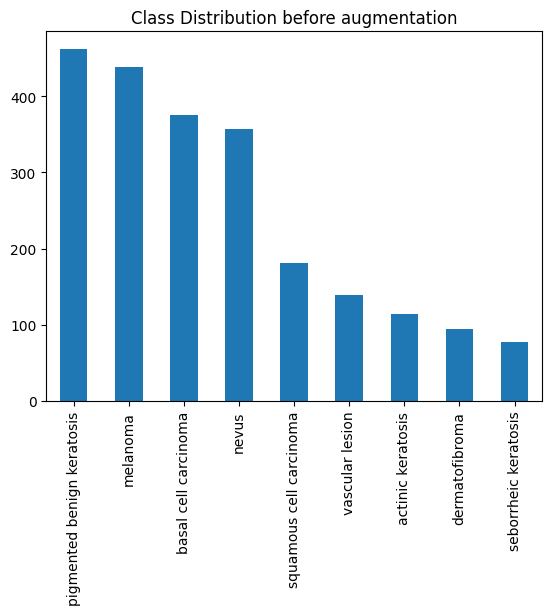

In [29]:
original_df.Label.value_counts().plot(kind='bar')
plt.title("Class Distribution before augmentation")
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


**Least samples** are from class ***seborrheic keratosis***.
**Most samples** are from class
***pigmented benign keratosis***.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset=str(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + '/' + str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E070C620D30>: 100%|██████████| 500/500 [00:18<00:00, 27.51 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E08801FBDC0>: 100%|██████████| 500/500 [00:21<00:00, 23.26 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E087C630AC0>: 100%|██████████| 500/500 [00:20<00:00, 24.44 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x542 at 0x7E070C612C20>: 100%|██████████| 500/500 [01:34<00:00,  5.29 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2530x2122 at 0x7E08801FBE50>: 100%|██████████| 500/500 [01:04<00:00,  7.73 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E08801BB6D0>: 100%|██████████| 500/500 [00:15<00:00, 32.11 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E08801FAC20>: 100%|██████████| 500/500 [00:36<00:00, 13.64 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E070C623C10>: 100%|██████████| 500/500 [00:15<00:00, 32.67 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E070C63C460>: 100%|██████████| 500/500 [00:15<00:00, 32.26 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031175.jpg_369b509e-4981-4071-a8dd-58f15b5c8158.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029747.jpg_b59ee493-bd1b-4115-8e7e-ad72d52866d1.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029539.jpg_1f67373d-4735-4f67-a1c7-703a60f9c1b6.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024550.jpg_f7c8cd5e-8af7-4841-9018-bbf126116f21.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028283.jpg_90fde55c-1411-4e78-a022-8513dfc16182.jpg',
 '/content/Skin

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-36-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [37]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

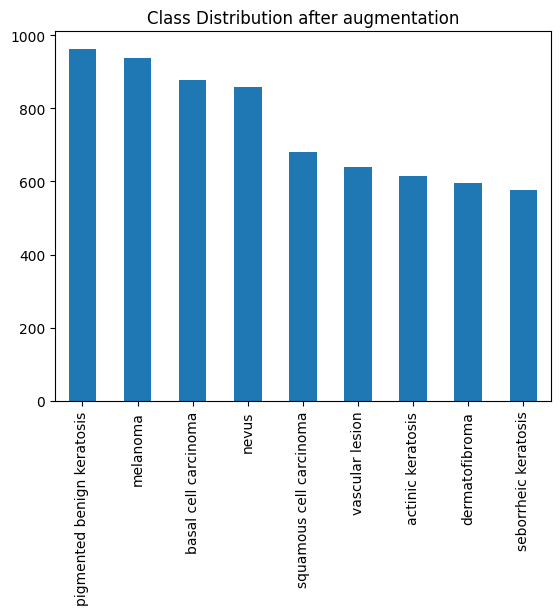

In [38]:
new_df['Label'].value_counts().plot(kind='bar')
plt.title("Class Distribution after augmentation")
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [40]:
data_dir_train=pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))+len(list(data_dir_train.glob('*/output/*.jpg')))
print("Number of images in Train dataset - ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of images in Test dataset - ",image_count_test)

Number of images in Train dataset -  6739
Number of images in Test dataset -  118


In [41]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
## your code goes here
cnnModelAugmentRebalance = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(9)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
## your code goes here
cnnModelAugmentRebalance.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [45]:
epochs = 50
## Your code goes here, use 50 epochs.
history = cnnModelAugmentRebalance.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 46s 249ms/step - loss: 1.8047 - accuracy: 0.3108 - val_loss: 1.4570 - val_accuracy: 0.4432
Epoch 2/50
169/169 [==============================] - 27s 157ms/step - loss: 1.4400 - accuracy: 0.4585 - val_loss: 1.2912 - val_accuracy: 0.5293
Epoch 3/50
169/169 [==============================] - 27s 155ms/step - loss: 1.2465 - accuracy: 0.5399 - val_loss: 1.2296 - val_accuracy: 0.5568
Epoch 4/50
169/169 [==============================] - 26s 149ms/step - loss: 1.0855 - accuracy: 0.6085 - val_loss: 1.2222 - val_accuracy: 0.5702
Epoch 5/50
169/169 [==============================] - 28s 156ms/step - loss: 0.9423 - accuracy: 0.6565 - val_loss: 0.9945 - val_accuracy: 0.6221
Epoch 6/50
169/169 [==============================] - 27s 150ms/step - loss: 0.7845 - accuracy: 0.7131 - val_loss: 0.9215 - val_accuracy: 0.6756
Epoch 7/50
169/169 [==============================] - 27s 153ms/step - loss: 0.6526 - accuracy: 0.7708 - val_loss: 0.9554 - val_ac

#### **Todo:**  Visualize the model results

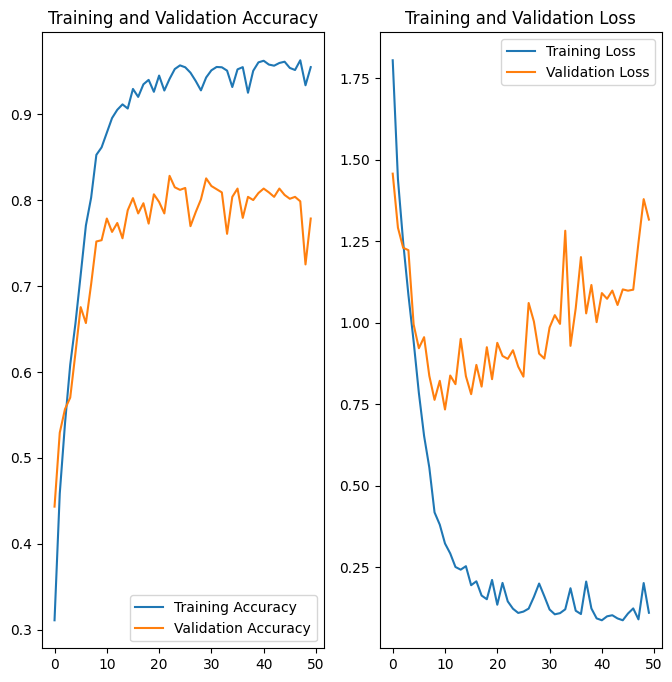

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [47]:
loss, accuracy = cnnModelAugmentRebalance.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = cnnModelAugmentRebalance.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 5s 93ms/step - loss: 1.3160 - accuracy: 0.7788
Accuracy:  0.9502967596054077
Validation Accuracy:  0.7787676453590393
Loss:  0.14101159572601318
Validation Loss 1.3160477876663208


***Model accuracy is ~95% in training*** and ***~77 in validation dataset***.

*Overfitting is addressed and rebalancing helped*.

Model accuracy is well within acceptance range.

In [48]:
tf.__version__

'2.14.0'

In [49]:
keras.__version__

'2.14.0'